In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

import torch
import torch.nn as nn
import torch.optim as optim
import time
import importlib

import coefficient
importlib.reload(coefficient)
from coefficient import *

import utils
importlib.reload(utils)
from utils import approx_m, plot_learning_summary

from triplet import bm_triplet

import shadow_market
importlib.reload(shadow_market)
from shadow_market import Shadow_Price

## To tun the method

Choose accoding to the abreviations of Chapter 3 in thesis.pdf:

In [27]:
hidden_formular = 'unexplicit' #choose from: 'unexplicit','explicit'
method='oracle' #choose from: 'oracle','baseline'
nn_in_dim=3 #choose from: 2,3; where 2 corresponds to the input Y and 3 to the input (Y,m)
activation='non_relu'# choose from: 'non_relu,'relu'

sigma=0.4 #choose sigma and mu such that sigma**2>mu>0
mu=0.08

In [ ]:
shadow_price = Shadow_Price(mu=mu,sigma=sigma,learn_s=True,x=100,hidden_formular=hidden_formular ,method=method,nn_in_dim=nn_in_dim,smooth_f = True,smooth_ddf=True,activation='non_relu')
shadow_price.train(3*10**3,lrs=[1e-3],plot=False,show_plot=200,plot_loss=True,interstep=1000)

## To save the plots and the trained neural networks in /results/name/

In [ ]:
name='name'+shadow_price.stamp

In [ ]:
directory1 ='./results/%s/'%(name)
directory2 ='./results/%s/trained_nn/'%(name)

directory3 = './results/%s/intermediate_pi/'%(name)

if not os.path.exists(directory1):
            os.makedirs(directory1)
        
if not os.path.exists(directory2):
    os.makedirs(directory2)
    
if not os.path.exists(directory3):
    os.makedirs(directory3)

PATH_drift = './results/%s/trained_nn/drift.pth'%(name)
torch.save(shadow_price.drift.state_dict(), PATH_drift)

PATH_diffusion = './results/%s/trained_nn/diffusion.pth'%(name)
torch.save(shadow_price.diffusion.state_dict(), PATH_diffusion)

PATH_s = './results/%s/trained_nn/s.pth'%(name)
torch.save(shadow_price.s, PATH_s)

PATH_training = './results/%s/train_loss.pt'%(name)
torch.save(torch.tensor(shadow_price.training_loss),PATH_training)

for (i,pi) in  enumerate(shadow_price.intermediate_pi):
    PATH_pi_i = './results/%s/intermediate_pi/_%i.pt'%(name,i)
    torch.save(torch.tensor(pi),PATH_pi_i)
    
poi = []
poi.append(shadow_price.intermediate_pi[0]) 
poi.append(shadow_price.intermediate_pi[1]) 
poi.append(shadow_price.intermediate_pi[-1])

plot_learning_summary(shadow_price.training_loss,SellBoundary,BuyBoundary,poi,name=name,save=True)
shadow_price.plot_strategy_and_fraction(1000,name=name,save=True)
shadow_price.plot_processes(1000,save=True,name=name)

eotw_prediction = torch.zeros(10)

for i in range(10):
    X, S, P, ETW, PI, PI_t, SB, SR, LOSS, A, B, Y = shadow_price.predict(1000)
    eotw_prediction[i] = ETW

mean_prediction = torch.mean(eotw_prediction).item()
std_prediction = torch.std(eotw_prediction).item()

lines = ['mean of prediction of eotw: %s\n'%(str(mean_prediction)),'std of prediction of eotw: %s'%(str(std_prediction)),]
with open('./results/%s/mean_std_eotw.txt'%(name), 'w') as f:
    f.writelines(lines)

## To load a pretrained neural network from /results/name/

In [31]:
name = '3Y_m/Non_relu_OracleTanh_e__350130'

hidden_formular = 'unexplicit' #choose from: 'unexplicit','explicit'
method='oracle' #choose from: 'oracle','baseline'
nn_in_dim=3 #choose from: 2,3; where 2 corresponds to the input Y and 3 to the input (Y,m)
activation='non_relu'# choose from: 'non_relu,'relu'

sigma=0.4 #choose sigma and mu such that sigma**2>mu>0
mu=0.08

In [32]:
shadow_price = Shadow_Price(mu=mu, sigma=sigma,learn_s=True,x=100,hidden_formular=hidden_formular,method=method,nn_in_dim=nn_in_dim,activation=activation,smooth_f=True,smooth_ddf=True)

PATH_drift = './results/%s/trained_nn/drift.pth'%(name)
PATH_diffusion = './results/%s/trained_nn/diffusion.pth'%(name)
PATH_s = './results/%s/trained_nn/s.pth'%(name)

shadow_price.drift.load_state_dict(torch.load(PATH_drift))
shadow_price.diffusion.load_state_dict(torch.load(PATH_diffusion))
shadow_price.s = torch.load(PATH_s)

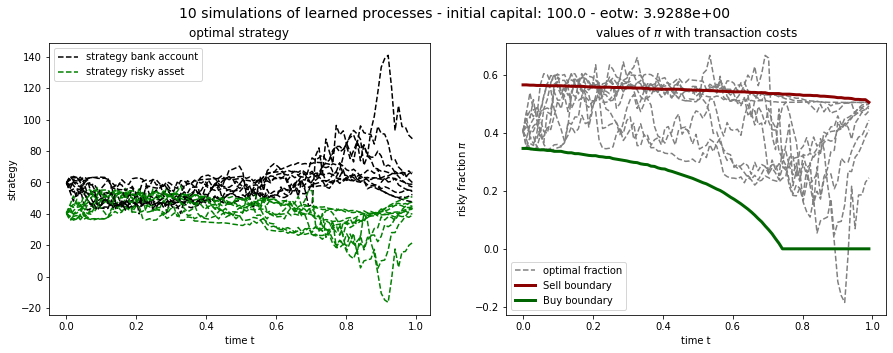

In [138]:
shadow_price.plot_strategy_and_fraction(10,name=name,save=True)

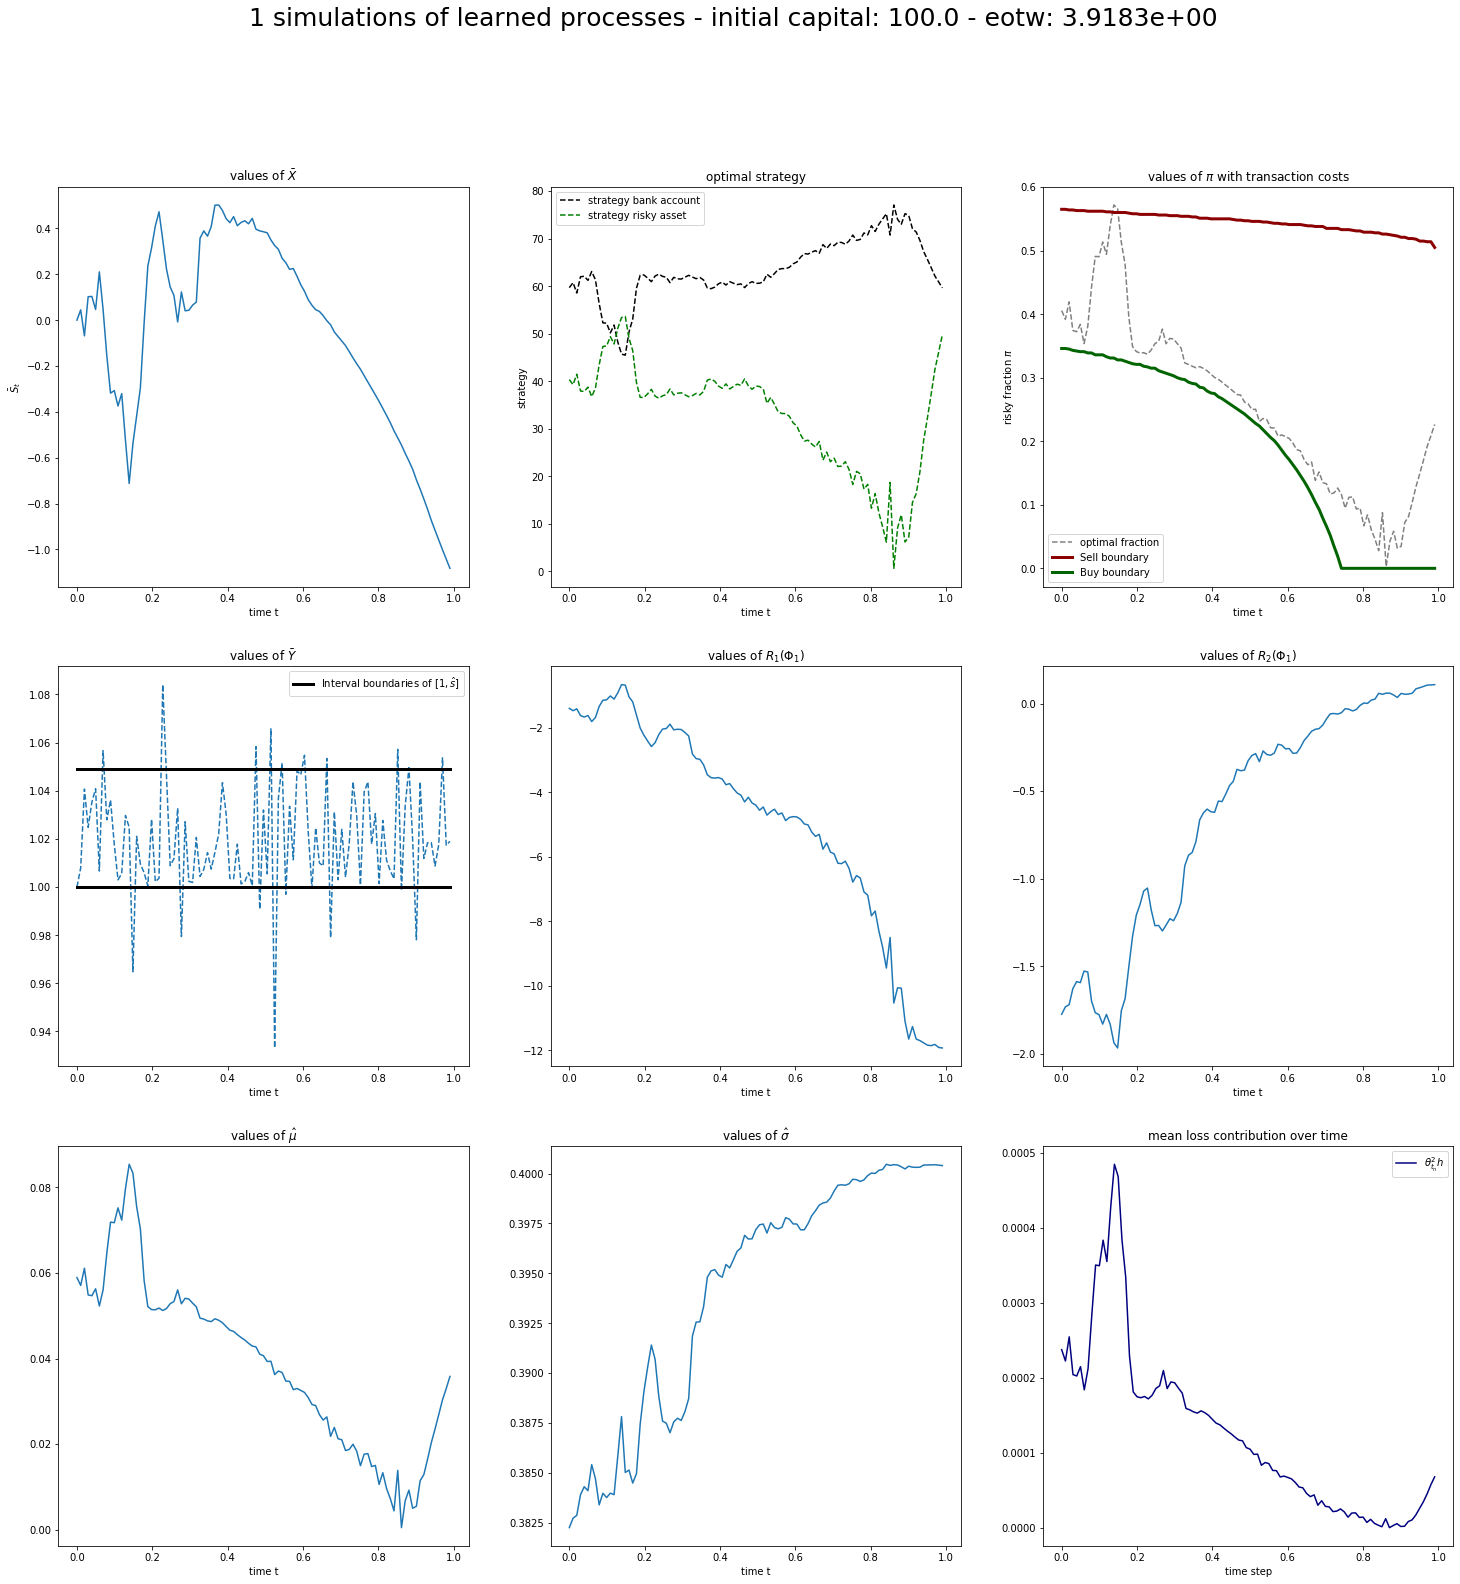

For initial capital 100.0000 the expected utility of the terminal wealth is 3.9183e+00


In [146]:
shadow_price.plot_processes(1,name=name,save=True)